In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(1)  when you have multiple GPUs, use this to set which GPU you want to run this on
# since I am using Colab, I am commenting the above line

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

In [0]:
PATH = Path('data/pascal')
# for i in PATH.iterdir(): print(i)
# [i for i in PATH.iterdir()]
list(PATH.iterdir())
# when libs dont support pathlib directly, convert object to string like below:
# 0 = list(PATH.iterdir())[0]
# str(o) 
# o will now have path in format that supports cv2
# pathlib has open method()

[PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [0]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()
# original Pascal dataset comes in xml since json is more widely used someone took the time and converted it into json

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]
# we used capitals so that its easy to trace

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [0]:
trn_j[ANNOTATIONS][:2]
# bbox is the bounding box, 
# dimensions are top left, bottom right, height, width
# 

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [0]:
trn_j[CATEGORIES][:8]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]
# when working with a new dataset, try to organise it the way you want
# so that it makes sense to you while working on it
# you actually dont know what you are doing, do you?
# ML and DL can be frustrating, theory is about loss function architecture and modeling
# in practice its not like that
# stick with it

In [0]:
trn_j[CATEGORIES]
trn_ids

In [0]:
import os
os.chdir('pascal')
!ls

pascal_test2007.json   pascal_val2007.json  VOC2012
pascal_train2007.json  pascal_val2012.json  VOCtrainval_06-Nov-2007.tar
pascal_train2012.json  VOC2007		    VOCtrainval_11-May-2012.tar


In [0]:
(PATH/'VOC2007').iterdir()

<generator object Path.iterdir at 0x7f4b6c69e938>

In [0]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOC2007/Annotations'),
 PosixPath('data/pascal/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOC2007/JPEGImages')]

In [0]:
JPEGS = 'VOC2007/JPEGImages'
#os.chdir('..')
!ls

data  datalab  drive  fastai


In [0]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOC2007/JPEGImages/009121.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/003280.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/006458.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/004239.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/005136.jpg')]

Each image has a unique ID.

In [0]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [0]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        # if dict item doesnt exist yet,it should be created
        # when naming variables, space vise, it should be one eye grab
        # your eye should not jump to read one variable
        # also make them vocal, put some sense into them
        # his philosophy is between math and java
        # not a single char as math, or too many as in java
        # switched x and y coordinates, in CV width comes first, so we interchanged
        # python and CV uses width by height
        # this is annoying inconsistency
        # 
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)
trn_anno #some images will have multiple boxes

In [0]:
im_a = trn_anno[im0_d[ID]]; 
im_a

[(array([ 96, 155, 269, 350]), 7)]

In [0]:
im_0a = im_a[0];
im_0a

(array([ 96, 155, 269, 350]), 7)

In [0]:
cats[7]

'car'

In [0]:
trn_anno[17] # has two bounding boxes

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [0]:
cats[15],cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])
# bounding box to height and width

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F2</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [0]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])
im
# how do we know what is open_image and what it does?
# browse the code
# we use cv2 in open_image; PyT libs use PyT tensors, some people use PIL
# after a lot of testing, opencv was 5 to 10 times faster
# PIL was faster but not as fast as CV2
# Pytons global inerpreter lock doesnt allow 2 threads to work on same task
# the global interpreter lock, or GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once
# fast.ai is fast because it makes use of multiple threads using CV2

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    # one plot or multiple plots, no harm in having subplots
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [0]:
# putting label on image, color is important so that it doenst go unnoticed
def draw_outline(o, lw): 
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    # if you are using something often inside a file, put it inside a func
    # if you are using something often across files, put it in a lib
    # here we draw outline and rectangle aroudn object, so make it a func
    

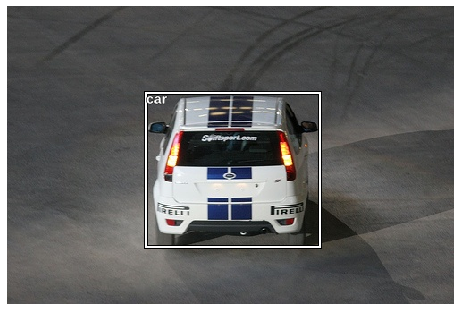

In [0]:
ax = show_img(im)
b = bb_hw(im_0a[0]) # tranfer dimensions for compatibility
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im_0a[1]])

In [0]:
def draw_im(im, ann): # draw an image with the annotation
    ax = show_img(im, figsize=(16,8)) # show the image
    for b,c in ann: # bounding box and class/category
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)
# J didnt know about object detection

(364, 480, 3)


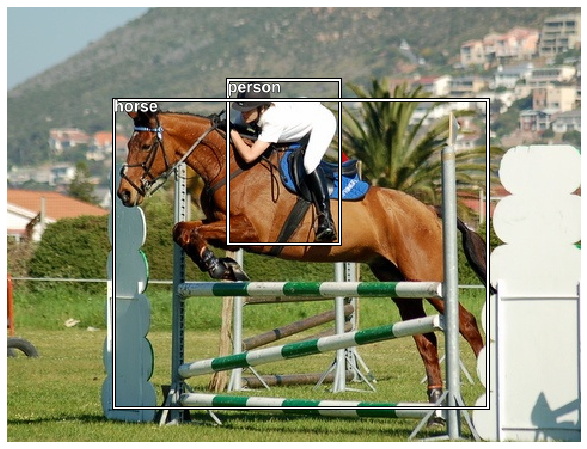

In [0]:
draw_idx(17)

## Largest item classifier

In [0]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]
# problem with researchers/students: they start with something big, do all the hardwork
# but fail just before delivering
# J approach - start small. Half an hour a day or 45mins
# we want the largest bb. we could use a method for this if it exists already
# if not, assume you have such a method, write the statement, 
# then start to build the method on your own
# give some ideas 

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

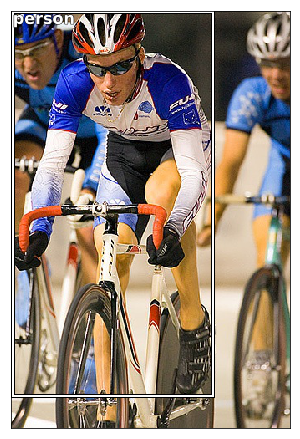

In [0]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)


In [0]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False) # dict doesnt have an order so we gave columns

In [0]:
f_model = resnet34 # from here on it's cats and dogs
sz=224
bs=64

In [0]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

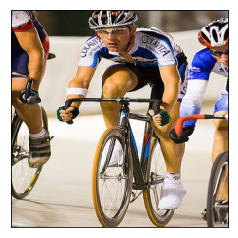

In [0]:
x,y=next(iter(md.val_dl)) # iter is important here, iters always have both dependent and independent variable
show_img(md.val_ds.denorm(to_np(x))[0]);
# our original image is not normalized or scaled
# denorm

In [0]:
# crop_type - default strategy for large images is having a random crop
# we dont do that for BB because unlike IN where images are at center
# here its not so, so cropping at center might cause bad results
# above we squashed instead of cropping. since we are not cropping, to make the bb square, it is squashed
# crop works better tan squish, gives better results
# 
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [0]:
lrf=learn.lr_find(1e-5,100)

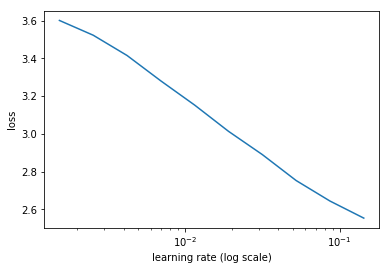

In [0]:
learn.sched.plot()

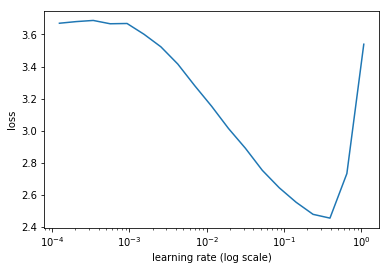

In [0]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [0]:
lr = 2e-2

In [0]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.335532   0.6443     0.804838  



[0.6443001, 0.80483774095773697]

In [0]:
lrs = np.array([lr/1000,lr/100,lr])

In [0]:
learn.freeze_to(-2)

A Jupyter Widget

 84%|████████▍ | 27/32 [00:07<00:01,  3.76it/s, loss=4.99] 


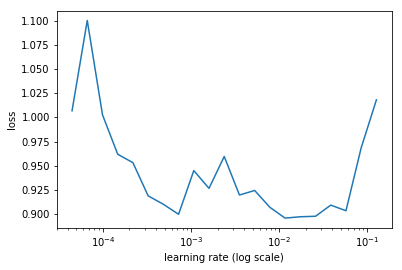

In [0]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.780925   0.575539   0.821064  



[0.57553864, 0.82106370478868484]

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/5, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.609306   0.570568   0.821514  
    1      0.462856   0.574303   0.8128                    



[0.57430345, 0.81280048191547394]

In [0]:
# we are stuck at 80%
# because pascal is different from image net
learn.save('clas_one')

In [0]:
learn.load('clas_one')

In [0]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

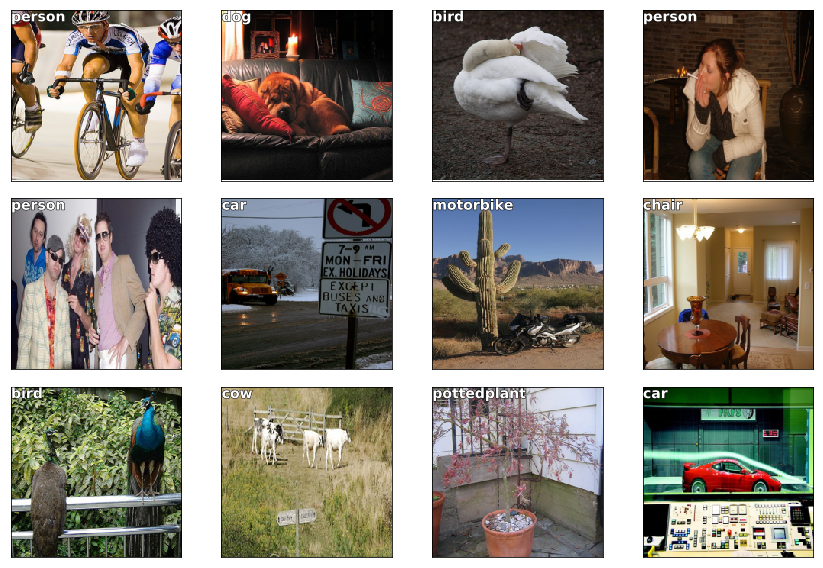

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    # start using python debugger 
    # pdb.set_trace()
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()
# %debug is a handy tool
# J does all his dev both for class and lib on jupyter
# he uses debugger and moving frequent code to methods
# creating bounding box may seem like new, but we have done it before
# classification neural net has sigmoid or softmax  and use CE or binary CE
# if we dont have softmax and use MSE, and predict continuous value, its regressin NN
# we got 4 nums - top left x and y, bottom right x and y
# i need 4  numbers, for that neural net needs 4 activations with MSE - this is differential programming
#  

## Bbox only

In [0]:
BB_CSV = PATH/'tmp/bb.csv'

In [0]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [0]:
f_model=resnet34
sz=224
bs=64

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)#, num_workers=0)

In [0]:
x,y=next(iter(md.val_dl))

In [0]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([  49.,    0.,  131.,  205.], dtype=float32)

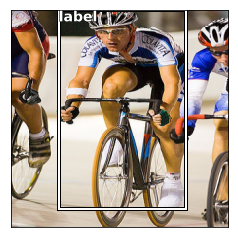

In [0]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [0]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
# pretrained resnet with custom layers
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()


A Jupyter Widget

 78%|███████▊  | 25/32 [00:04<00:01,  6.16it/s, loss=395] 


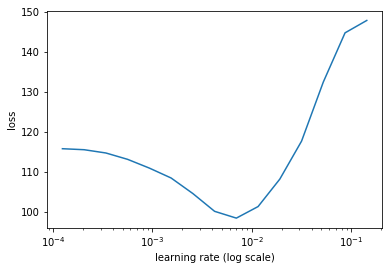

In [0]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [0]:
lr = 2e-3

In [0]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      49.523444  34.764141 
    1      36.864003  28.007317                           
    2      30.925234  27.230705                           



[27.230705]

In [0]:
lrs = np.array([lr/100,lr/10,lr])

In [0]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      102.406115 91141120000.0



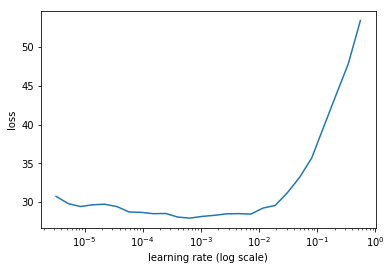

In [0]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      25.616161  22.83597  
    1      21.812624  21.387115                           
    2      17.867176  20.335539                           



[20.335539]

In [0]:
learn.freeze_to(-3)

In [0]:
learn.fit(lrs, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      16.571885  20.948696 
    1      15.072718  19.925312                           



[19.925312]

In [0]:
learn.save('reg4')

In [0]:
learn.load('reg4')

In [0]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

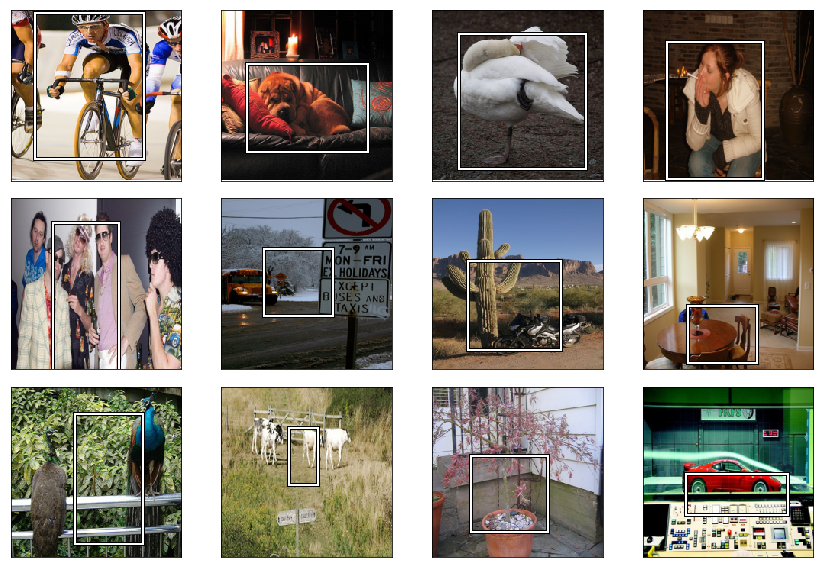

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()
# when there is ambiguity, like two people or two birds,
# model will take the middle path

## Single object detection

In [0]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, num_workers=4, val_idxs=val_idxs)

In [0]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [0]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [0]:
x,y=next(iter(md.val_dl))

In [0]:
ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([   1.,   63.,  222.,  159.], dtype=float32)

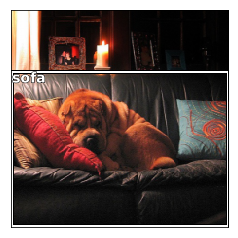

In [0]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [0]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [0]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

A Jupyter Widget

 97%|█████████▋| 31/32 [00:07<00:00,  4.32it/s, loss=920]


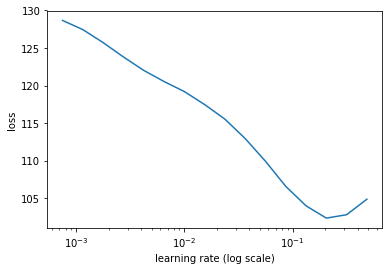

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=1e-2

In [0]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      73.927436  47.326687  0.799129   34.355363 
    1      52.524767  36.633926  0.821514   25.356636     
    2      42.088353  35.808929  0.840144   24.928916     



[35.808929, 0.84014423191547394, 24.928915977478027]

In [0]:
learn.save('reg1_0')

In [0]:
learn.freeze_to(-2)

In [0]:
lrs = np.array([lr/100, lr/10, lr])

A Jupyter Widget

 91%|█████████ | 29/32 [00:09<00:01,  2.99it/s, loss=308] 


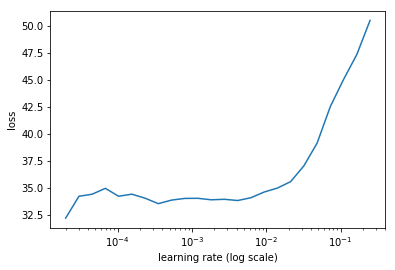

In [0]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [0]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.996194  36.883408  0.810998   23.902456 
    1      28.962542  33.961132  0.807542   21.788602     
    2      24.479901  31.829189  0.816256   20.760759     
    3      21.002628  31.217596  0.827524   20.065778     
    4      18.563346  31.386042  0.819712   19.966886     



[31.386042, 0.81971153616905212, 19.966886043548584]

In [0]:
learn.save('reg1_1')

In [0]:
learn.load('reg1_1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.8324    31.657162  0.813852   20.311439 
    1      16.053105  31.920698  0.819111   20.126827     
    2      15.587304  31.761778  0.813401   19.608653     
    3      14.946252  31.8496    0.82512    19.494941     
    4      14.286875  31.694134  0.813852   19.520903     
    5      13.687061  31.146765  0.810998   19.118674     
    6      12.972183  30.679935  0.802734   18.846736     
    7      12.234888  30.844444  0.812951   18.867411     
    8      11.729662  30.820433  0.8125     18.726339     
    9      11.324294  30.836037  0.812951   18.648762     



[30.836037, 0.81295072287321091, 18.648761749267578]

In [0]:
learn.save('reg1')

In [0]:
learn.load('reg1')

In [0]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [0]:
from scipy.special import expit

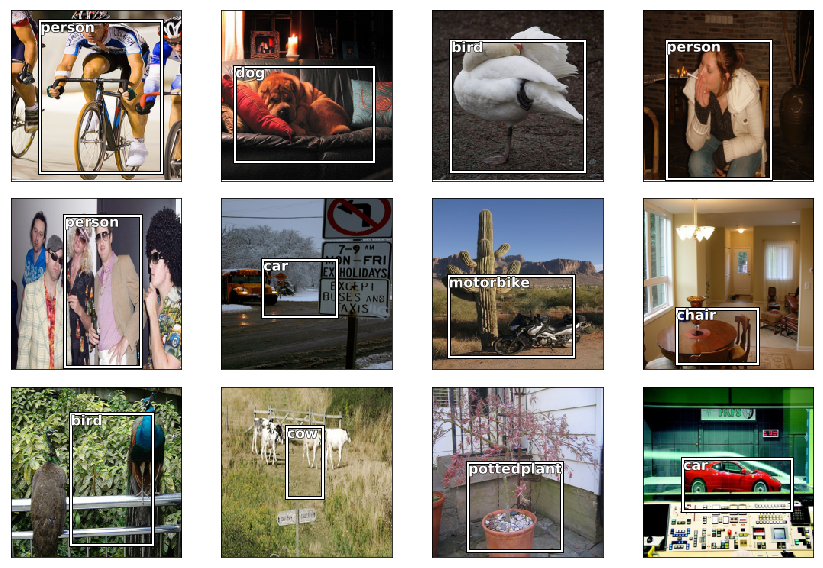

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End